# Optimizing Dry Bean Sorting into Classes using Classification with K-nearest neighbors

## Introduction:

Dry beans, scientifically known as Phaseolus vulgaris L., are a crucially important and widely produced pulse globally (Beebe et al., 2013). In Turkish agriculture, dry beans play a significant role as a dinner table staple in many households. Turkey has several varieties of dry beans, including Barbunya, Battal, Bombay, Calı, Dermason, Horoz, Tombul, Selanik, and Seker. However, the market value of dry beans depends on the specific type of bean, and some beans are sold for higher prices than others.

The cultivation of the seven different beans together makes sorting them a crucial task (Koklu & Ozkan, 2020). Rather than selling them as a mixed batch, farmers can make more profit by sorting them by bean type. Manual classification and sorting of bean seeds can be tedious and time-consuming, especially when dealing with high production volumes. Manual sorting is costly and can vary in accuracy by individual, which has led to growing interest in automatic sorting systems. Computer algorithms can analyze images of seeds and classify them based on features like size and shape, making sorting faster, more accurate, and less labor-intensive than manual sorting.

In this project, we are interested in seed classification within the context of our dataset, which identifies the seven different types of dry beans cultivated in Turkey based on their physical features according to the Turkish Standards Institution. This research uses images of seven varieties of dry beans generated by a computer vision system, examining 16 features of the grains (Koklu & Ozkan, 2020). Our aim in this project is to create a k-NN classifier that can classify dry bean seeds.


**Predictive question**: Can we accurately predict bean type (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira) using physical features of the dry beans?

Figure 1: Image of the Seven Types of Dry Beans

![](https://ars.els-cdn.com/content/image/1-s2.0-S0168169919311573-gr3.jpg)



### Variables of Interest:

| Variable Name  | Description                                 |
|--------|---------------------------------------------|
| Area (A)     | The area of a bean zone and the number of pixels within its boundaries.            |
|Perimeter (P)    | Bean circumference is defined as the length of its border.         |
| Major axis length (L)    | The distance between the ends of the longest line that can be drawn from a bean     |
|  Minor axis length (l)    | The longest line that can be drawn from the bean while standing perpendicular to the main axis |
| Aspect ratio (K)     | Defines the relationship between L and l           |
|Eccentricity (Ec)    | Eccentricity of the ellipse having the same moments as the region        |
| Convex area (C)    | Number of pixels in the smallest convex polygon that can contain the area of a bean seed      |
|  Equivalent diameter (Ed)   | The diameter of a circle having the same area as a bean seed area. |
| Extent (Ex)    |The ratio of the pixels in the bounding box to the bean area.            |
|Solidity (S)    | Also known as convexity. The ratio of the pixels in the convex shell to those found in beans          |
| Roundness (R)    |Calculated with the following formula: (4piA)/(P^2)   |
|  Compactness (CO)    |Measures the roundness of an object: Ed/L |
| ShapeFactor1 (SF1)    |Not specified in orginal dataset         |
|ShapeFactor2 (SF2)    |Not specified in orginal dataset         |
| ShapeFactor3 (SF3)   |Not specified in orginal dataset        |
|  ShapeFactor4 (SF4)   |Not specified in orginal dataset  |
| Class   | Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)|





### Methods & Results:

In [3]:
# Download libraries
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("visdat")
library(visdat)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
# set seed
set.seed(25)

In [5]:
# Read dataset

url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
bean_data <- read_csv(url)|> mutate(Class=as_factor(Class))

# remove missing values if any
bean_data <- filter(bean_data, rowSums(is.na(bean_data)) != ncol(bean_data))

Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
#Wrangle/clean data 

clean_bean_data<-bean_data|>
mutate(Class=as_factor(Class))

clean_bean_data<-na.omit(clean_bean_data)

clean_bean_data

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON
42147,763.779,283.3826,190.2757,1.489326,0.7410548,42667,231.6532,0.7053891,0.9878126,0.9079065,0.8174575,0.006723673,0.001852025,0.6682367,0.9952224,DERMASON
42159,772.237,295.1427,182.2047,1.619841,0.7866930,42600,231.6862,0.7889625,0.9896479,0.8883804,0.7849972,0.007000705,0.001639812,0.6162206,0.9981796,DERMASON


#### Data set exploration summary


In [7]:
# Name of each category in Class column
clean_bean_data |>
  pull(Class) |>
  levels()

[1] "SEKER"    "BARBUNYA" "BOMBAY"   "CALI"     "HOROZ"    "SIRA"     "DERMASON"

In [8]:
# Number and percentage of each category.
 
num_obs <- nrow(clean_bean_data)

bean_number<-clean_bean_data|>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)|>
    arrange(count)
print(bean_number)



# A tibble: 7 × 3
  Class    count percentage
  <fct>    <int>      <dbl>
1 BOMBAY     522       3.84
2 BARBUNYA  1322       9.71
3 CALI      1630      12.0 
4 HOROZ     1928      14.2 
5 SEKER     2027      14.9 
6 SIRA      2636      19.4 
7 DERMASON  3546      26.1 


The above count table shows that the class DERMASON has the highest number of observations. It occupies about 26.1 % of the total observations in the dataset while seed BOMBAY has the lowest number of observations with about 3.84% of the total observations. The different ratio of observations of each class might affect the classifictaion model.

In [9]:
#Create the train/ test split
bean_split <- initial_split(clean_bean_data, prop = 0.50, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

In [10]:
glimpse(bean_train)

Rows: 6,804
Columns: 17
$ Area            <dbl> 43145, 47149, 49755, 50167, 50575, 51015, 52839, 53525…
$ Perimeter       <dbl> 799.426, 857.690, 868.813, 873.825, 858.520, 859.253, …
$ MajorAxisLength <dbl> 273.4029, 300.2879, 332.0911, 309.8928, 314.3268, 327.…
$ MinorAxisLength <dbl> 201.2669, 200.3199, 191.9921, 206.7724, 205.4663, 198.…
$ AspectRation    <dbl> 1.358410, 1.499042, 1.729713, 1.498715, 1.529822, 1.65…
$ Eccentricity    <dbl> 0.6768132, 0.7449746, 0.8159441, 0.7448443, 0.7567789,…
$ ConvexArea      <dbl> 43812, 48091, 50783, 50937, 51389, 51718, 53489, 54660…
$ EquivDiameter   <dbl> 234.3799, 245.0142, 251.6943, 252.7343, 253.7599, 254.…
$ Extent          <dbl> 0.7661233, 0.7207674, 0.7342828, 0.7945989, 0.7121233,…
$ Solidity        <dbl> 0.9847759, 0.9804121, 0.9797570, 0.9848833, 0.9841600,…
$ roundness       <dbl> 0.8483671, 0.8054186, 0.8283120, 0.8256178, 0.8622733,…
$ Compactness     <dbl> 0.8572690, 0.8159311, 0.7579074, 0.8155538, 0.8073124,…
$ ShapeFactor1  

In [11]:
glimpse(bean_test)

Rows: 6,807
Columns: 17
$ Area            <dbl> 28395, 30008, 30279, 30519, 30685, 30917, 31091, 31107…
$ Perimeter       <dbl> 610.291, 645.884, 634.927, 629.727, 635.681, 640.765, …
$ MajorAxisLength <dbl> 208.1781, 210.5580, 212.5606, 212.9968, 213.5341, 213.…
$ MinorAxisLength <dbl> 173.8887, 182.5165, 181.5102, 182.7372, 183.1571, 184.…
$ AspectRation    <dbl> 1.197191, 1.153638, 1.171067, 1.165591, 1.165852, 1.15…
$ Eccentricity    <dbl> 0.5498122, 0.4986160, 0.5204007, 0.5137596, 0.5140809,…
$ ConvexArea      <dbl> 28715, 30724, 30600, 30847, 31044, 31280, 31458, 31423…
$ EquivDiameter   <dbl> 190.1411, 195.4671, 196.3477, 197.1243, 197.6597, 198.…
$ Extent          <dbl> 0.7639225, 0.7826813, 0.7756885, 0.7706818, 0.7715615,…
$ Solidity        <dbl> 0.9888560, 0.9766957, 0.9895098, 0.9893669, 0.9884358,…
$ roundness       <dbl> 0.9580271, 0.9039364, 0.9438518, 0.9671092, 0.9542398,…
$ Compactness     <dbl> 0.9133578, 0.9283288, 0.9237260, 0.9254804, 0.9256585,…
$ ShapeFactor1  


We can observe from glimpse in the code above that the training set contains 6804 observations, while the test set contains 6807 observations. This corresponds to a train / test split of 50% / 50%, as desired.

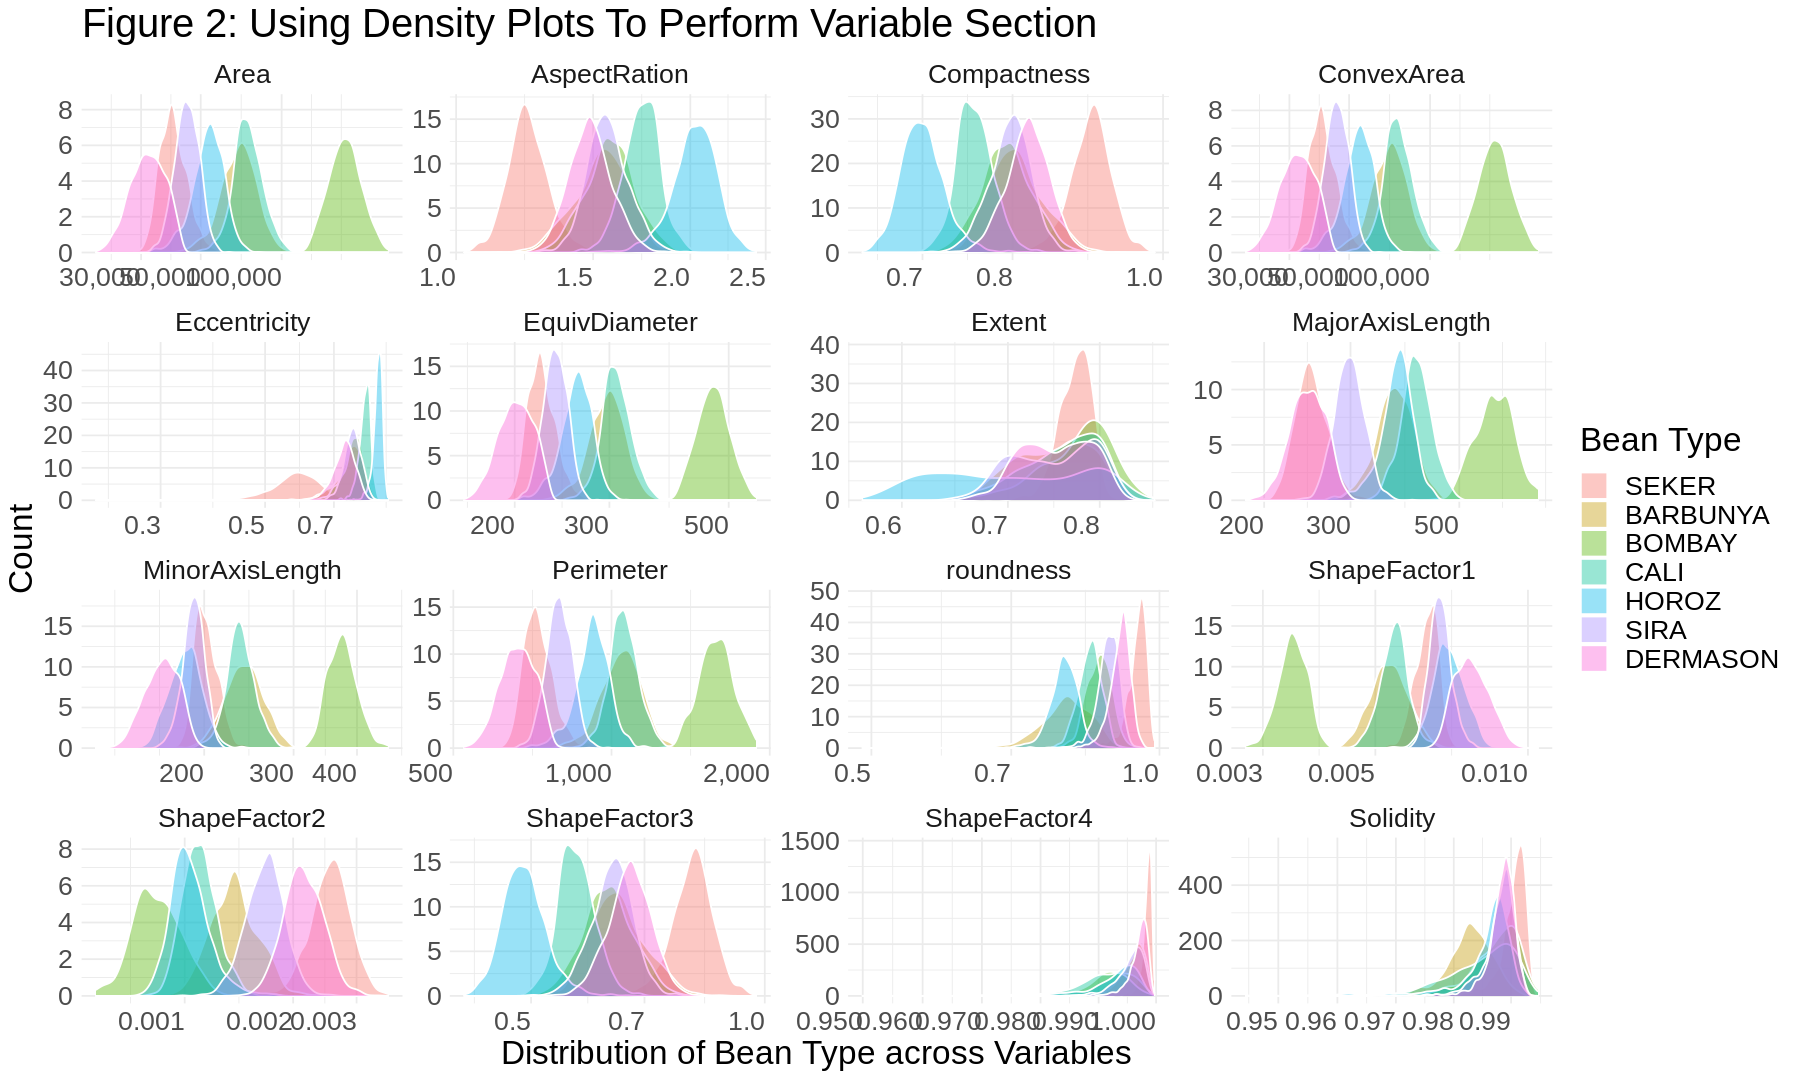

In [12]:
# Predictor selection
options(repr.plot.height = 9, repr.plot.width = 15)
bean_train |>
    pivot_longer(cols = -Class, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = Class)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        labs(x="Distribution of Bean Type across Variables", y="Count", fill="Bean Type")+
        ggtitle("Figure 2: Using Density Plots To Perform Variable Section")+
        theme(text = element_text(size = 20)) +
 theme(axis.text.x = element_text( hjust =1)) +
  scale_x_log10(labels = label_comma())

To choose our predictors:

First, we removed variables we don't understand. These include shape factors 1, 2, 3, and 4.

Next, we removed variables that convey similar things making them redundant. When it comes to using them as predictors, this will cause our model to place a greater emphasis on those predictors since they're counted twice. The aspect ratio is the relationship between the major and minor axis of an object. So, we removed the major axis and minor axis.
Area is similar to perimeter. So, we removed the area.

Lastly, we utilized histograms to visualize the distribution of different variables. If the distributions between the graphs greatly overlap then it might not be a good predictor because if an unknown observation was used, it'd be within a cluster of many different bean types. If one distribution was skewed to the right and one distribution was skewed to the left, i.e. very little overlap that could be an indication of a good predictor. Referring to figure 2, distribution of the solidity graph shows notable overlap between every class of bean; thus, this variable was removed.

Therefore, we are left with and will be using the following variables to be used in our classifier: Area, AspectRation, Compactness, ConvexArea, Eccentricity, EquivDiameter, Extent, Perimeter, and Roundness.

In [13]:
#Update data set
bean_train<- bean_train|>
select("Area", "AspectRation", "Compactness", "ConvexArea", "Eccentricity",
       "EquivDiameter", "Extent", "Perimeter", "roundness", "Class")

bean_test<- bean_test|>
select("Area", "AspectRation", "Compactness", "ConvexArea", "Eccentricity",
       "EquivDiameter", "Extent", "Perimeter", "roundness", "Class")

Summary Table

In [ ]:
bean_mean <- bean_train|>
group_by(Class)|> summarise(mean_Perimeter = mean(Perimeter), 
                  mean_AspectRation = mean(AspectRation),
                  mean_Eccentricity = mean(Eccentricity),
                  mean_EquivDiameter = mean(EquivDiameter),
                  mean_roundness = mean(roundness),
                  mean_Compactness = mean(Compactness))
summary(bean_mean)

Class,mean_Perimeter,mean_AspectRation,mean_Eccentricity,mean_EquivDiameter,mean_roundness,mean_Compactness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEKER,727.8285,1.242545,0.5823238,224.9190,0.9440346,0.8977811
BARBUNYA,1047.6694,1.545283,0.7551870,297.6554,0.7996056,0.8047165
BOMBAY,1584.4410,1.581362,0.7697073,468.7764,0.8649683,0.7935748
⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,921.2335,2.028200,0.8678886,261.0240,0.7938218,0.7004579
SIRA,796.0900,1.570316,0.7672856,238.2273,0.8845669,0.7973208
DERMASON,665.0301,1.491969,0.7372672,201.6229,0.9080678,0.8187010


The above table summarises the mean of each predictor varibale grouped by its Class. 

In [35]:
# Table of standard deviation for each predictor by Class
bean_sd <- bean_train|>
group_by(Class)|>
summarise(sd_Perimeter = sd(Perimeter), 
          sd_AspectRation = sd(AspectRation),
          sd_Eccentricity = sd(Eccentricity),
          sd_EquivDiameter = sd(EquivDiameter),
          sd_roundness = sd(roundness),
          sd_Compactness = sd(Compactness))
summary(bean_sd)

# A tibble: 7 × 7
  Class    sd_Perimeter sd_AspectRation sd_Eccentricity sd_EquivDiameter
  <fct>           <dbl>           <dbl>           <dbl>            <dbl>
1 SEKER            48.4          0.0817          0.0722             13.3
2 BARBUNYA         90.7          0.125           0.0492             22.4
3 BOMBAY          116.           0.113           0.0387             31.8
4 CALI             68.4          0.0914          0.0224             19.6
5 HOROZ            68.5          0.132           0.0201             17.6
6 SIRA             44.8          0.0979          0.0330             12.3
7 DERMASON         50.3          0.0969          0.0399             14.7
# … with 2 more variables: sd_roundness <dbl>, sd_Compactness <dbl>


The above table shows the spread of values for each predictor variable grouped by its Class. The standard deviation shows the spread of variables in a Class.


### K Value Selection

In [16]:
bean_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

In [17]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [18]:
bean_recipe <- recipe(Class ~ ., data = bean_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
bean_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          9

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [19]:
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
k_vals

neighbors
<dbl>
1
2
3
⋮
13
14
15


In [ ]:
knn_results <- workflow() |>
  add_recipe(bean_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bean_vfold, grid = 15) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

In [ ]:
accuracies_max <- accuracies |>
arrange(mean)|>
tail(1)
accuracies_max

In [ ]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 18))+
ggtitle("Figure 3: Selecting the Best K")

accuracy_vs_k

In [ ]:
#NOTE: I added this version of the cross validation plot to see if it may be visually better
#Adjust the k value if we change best k = 10 to something else
options(repr.plot.width = 12, repr.plot.height = 7)

ky <- accuracies |>
    filter(neighbors == 13) |>
    select(mean) |>
    pull()

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 13, colour = "red") +
    geom_point(aes(x = 13, y = ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbours",
         y = "Accuracy Estimate\n",
         title = "Estimated Accuracies of k Neighbours") +
    scale_x_continuous(limits = c(1, 25),
                       breaks = seq(1, 25),
                       minor_breaks = seq(1, 25, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))+
ggtitle("Figure 3: Selecting the Best K Value")

cross_val_plot

Based on the findings presented in Figure 3, it can be concluded that a value of k=13 provides the highest estimated accuracy. Moreover, the graph indicates that the estimated accuracy remains relatively stable even if we slightly increase or decrease k around the value of 13. Furthermore, selecting k=13 does not result in a computationally expensive training process. Therefore, taking all these factors into consideration, we would choose k=13 as the optimal value for the classifier.

In [ ]:
# Make a new model specification for the best parameter value 

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(bean_recipe) |>
  add_model(knn_spec) |>
  fit(data = bean_train)
knn_fit

In [ ]:
# Evaluate the estimated accuracy of the classifier 

In [ ]:
bean_predictions <- predict(knn_fit, bean_test) |>
  bind_cols(bean_test)
bean_predictions

In [ ]:
levels(bean_predictions$.pred_class) <- levels(bean_predictions$Class)
bean_predictions |>
metrics(truth = Class, estimate =.pred_class)|>
filter(.metric == "accuracy")

# Summary Table

In [ ]:
confusion <- bean_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)
confusion



In [ ]:
# Heat map based on the confusion matrix
value =c(946,  6,  0,    2,     0,   19 ,      45,
      4,   548,      0,   21,     3,    4,  0,
      0,    0,    256,    0,     0,    0,    0,
      0,    74,      0,  785,    19,    2,    0,
      0,     3,      0,    7,   901,   10,    2,
      43,    16,      0,    7,    35, 1175,   120,
      17,     0,      0,   0,     6,  122,    1609)
predicted <- c(rep(c("SEKER", "BARBUNYA", "BOMBAY", "CALI", "HOROZ", "SIRA", "DERMASON"), 7))
actual <- c(rep("SEKER",7), rep("BARBUNYA",7), rep("BOMBAY",7),rep("CALI",7),rep("HOROZ",7),rep("SIRA",7),rep( "DERMASON",7))

conf_matriz <- tibble(actual, predicted, value)


# Heatmap for correlation of variables
heat_map <- ggplot(conf_matriz, aes(x = predicted, y= actual , fill = value)) +
  geom_tile(color = "white",
            lwd = 1.5,
            linetype = 1)+
    xlab("Predicted Bean Class")+
    ylab("Actual Bean Class")+
  geom_text(aes(label = value), color = "black", size = 4)+
  scale_fill_gradientn(colors = hcl.colors(30, "RdYlGn")) +
 guides(fill = guide_colourbar(title = "Count Values"))+
  ggtitle("Heatmap based of confusion matrix")+
    theme(text=element_text(size=15))
heat_map 


IRA and about 45 DERMASON seeds were identified SEKER. Also, about 122 SIRA seeds were identified DERMASON.This suggests that there might some physical similarities between DERMASON and SIRA seeds. In addition to this about 21 CALI seeds were misclassified as BARBUNYA and about 74 BARBUNYA seeds were misclassified as CALI. 

In [ ]:
confusion_values = c(946,5725,72,64,
                     548, 6128,32,63,
                     256, 6551,0,0,
                     785, 5890, 95,37,
                     901,5857, 15, 63,
                     1175, 5254, 221,157,
                     1609, 4886,191, 167)

class_name <- c(rep("SEKER",4), rep("BARBUNYA",4), rep("BOMBAY",4),rep("CALI",4),rep("HOROZ",4),rep("SIRA",4),rep( "DERMASON",4))
conf_outcomes <- c(rep(c("TP", "TN", "FP", "FN"), 7))
conf_tibble <- tibble(class_name, conf_outcomes, confusion_values)   
conf_tibble 

bean_bar <- ggplot(conf_tibble, aes(x = class_name, y = confusion_values, fill= conf_outcomes)) +
  geom_bar(stat = "identity", position=position_dodge())+
  labs(x="Bean Class", y= "Count", fill= "Confusion Matrix Outcomes")+
  ggtitle("Outcomes of confusion matrix")+
   geom_text(aes(label=confusion_values), position=position_dodge(width=0.9), vjust=-0.25)+
        theme(text=element_text(size=15))

bean_bar 
                                                                              
                                                                                                                                             

### Discussion:

summarize what you found 


Based on the above data analysis, the KNN classifier has an accuracy of about 91% in classifying seven different classes of seed which are 'SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', and 'DERMASON'. The confusion matrix and heatmap represent the summarisation of the predicted results.

The above heatmap gives a visual representation of the data analysis and accuracy of the model. The overall accuarcy of the model is quite good as it predicts about 91% correct observations however there are some seeds were misclassified. The diagonal of the heatmap depicts the correct predictions made by the model.The heatmap represents misclassified seeds which are less in number with red colour, while it depicts high misclassfication with orange.By observing the heatmap we find that about 120 DERMASON seeds were identified SIRA (as it has an orange colour) and about 45 DERMASON seeds were identified SEKER (light orange). Also, about 122 SIRA seeds were identified DERMASON and therefore, having ornage colour for depiction.This suggests that there might some physical similarities between DERMASON and SIRA seeds. In addition to this about 21 CALI seeds were misclassified as BARBUNYA and about 74 BARBUNYA seeds were misclassified as CALI. 





discuss whether this is what you expected to find?


Based on the dataset, we did not expect the classification model to achieve a 91% accuracy. The dataset contained 16 different variables, which could be used as predictors in the classification model. The higher number of predictors in a model often corresponds to less accuracy. Other than this the target variable of the dataset which is the CLASS has seven different types of seed. We saw this as a potential reason to decrease the accuracy of the model as the class 'BOMBAY' had about 3.84% observations in the dataset while the class 'DERMASOn' had about 26.1% observations in the dataset. This makes the data close to an imbalanced dataset and might make the model biassed towards one type.Other than this the seven different types of seed types increases the complexity and makes it challenging for the model to predict accurate seed type.

Checklist vv
1. summarize what you found
2. discuss whether this is what you expected to find?
3. discuss what impact could such findings have?

The selection of the optimal seed species is a crucial issue for bean farmers and the market alike. With a wide range of genotypes cultivated across the globe, it is imperative to differentiate the finest seed variety from the mixed dry bean population. If this is not done, the market value of these heterogeneous bean species may witness a significant decline, as pointed out by Varankaya and Ceyhan (2012). Findings from this study have significant implications for the agricultural industry, as development of automated image classification technology can improve efficiency and accuracy of dry bean sorting, reducing labor costs. Success could lead to research on applications of image classification models to other agricultural products (e.g., crops and fruits), or examining socio-economic impacts of this technology via agriculture, specifically potential for job displacement.

4. discuss what future questions could this lead to?

### References

Checklist
1. At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
2. Make sure to cite the source of your data as well.

 Beebe, S. E., Rao, I. M., Blair, M. W., & Acosta-Gallegos, J. A. (2013). Phenotyping common beans for adaptation to drought. Frontiers in Physiology, 4, 35-35. 
https://doi.org/10.3389/fphys.2013.00035

 KOKLU , M., &amp; OZKAN , I. A. (2020). Dry Bean Dataset. UCI Machine Learning Repository: Dry Bean Dataset Data set. Retrieved April 13, 2023, from https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset 


 Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507
 

 Varankaya, S., & Ceyhan, E. (2012). Problems Encountered in Bean Farming in the Central Anatolia Region and Solution Suggestions. Selçuk Tarım Bilim. Journal. 26, 15–26.

 Image source: https://www.sciencedirect.com/science/article/pii/S0168169919311573